# Kendrick Lamar Lyrics Generator using Markov Chains

Markov chain model to generate new lyrics in the style of Kendrick Lamar based on his existing lyrics.

In [62]:
import os
import sys
import random
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Loading and preprocessing lyrics data

In [63]:
def load_lyrics_from_csv(filepath):
    try:
        df = pd.read_csv(filepath)
        lyrics = df['lyrics'].dropna().astype(str).tolist()
        return lyrics
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return []


csv_path = "../data/cleaned_lyrics.csv"
if os.path.exists(csv_path):
    print(f"Loading lyrics from CSV: {csv_path}")
    lyrics_data = load_lyrics_from_csv(csv_path)
    print(f"Loaded {len(lyrics_data)} lyrics from CSV")
else:
    print("No lyrics data found. Please provide valid file paths.")
    lyrics_data = []

Loading lyrics from CSV: ../data/cleaned_lyrics.csv
Loaded 102 lyrics from CSV


## Preprocessing the lyrics

In [64]:
def preprocess_lyrics(lyrics_list):
    processed_lyrics = []
    
    for lyrics in lyrics_list:
        # Convert to lowercase
        lyrics = lyrics.lower()
        
        # Remove special characters but keep sentence punctuation
        lyrics = re.sub(r'[^\w\s.,!?\()" -]+', '', lyrics)
        
        # Split into sentences
        sentences = re.split(r'(?<=[.!?])\s+', lyrics)
        
        # Filter out empty sentences
        sentences = [s.strip() for s in sentences if s.strip()]
        
        processed_lyrics.extend(sentences)
    
    return processed_lyrics


if lyrics_data:
    processed_lyrics = preprocess_lyrics(lyrics_data)
    print(f"Processed {len(processed_lyrics)} sentences from the lyrics")
else:
    print("No lyrics data found.")
    processed_lyrics = []

Processed 907 sentences from the lyrics


## Implementing the Markov Chain Model

In [65]:
class MarkovModel:
    def __init__(self, order=2):
        self.order = order
        self.model = defaultdict(list)
        self.starts = []
        
    def train(self, sentences):
        for sentence in sentences:
            words = re.findall(r'\b\w+\b|[.!?,]', sentence.lower())
            
            if len(words) <= self.order:
                continue # this means sentence would be too short for training, not useful
                
            # Possible starting points for sentence generation
            self.starts.append(tuple(words[:self.order]))
            
            # Build the model
            for i in range(len(words) - self.order):
                context = tuple(words[i:i+self.order])
                next_word = words[i+self.order]
                self.model[context].append(next_word)
                
    def generate(self, seed_words=None, max_length=50):

        if not self.model:
            return "Model has not been trained yet."
            
        # Start with given seed or random start
        if seed_words and len(seed_words) >= self.order:
            current = tuple(seed_words[-self.order:])
            result = seed_words.copy()
        else:
            if not self.starts:
                return "Cannot generate text: no sentence starts found."
            current = random.choice(self.starts)
            result = list(current)
        
        # Generate words
        while len(result) < max_length:
            if current not in self.model:
                # If we hit a context not in our model, try to recover
                if len(result) >= self.order:
                    # Try to form a new context from the last words
                    current = tuple(result[-self.order:])
                    if current not in self.model:
                        break
                else:
                    break
            
            next_word = random.choice(self.model[current])
            result.append(next_word)
            
            # Update the context window
            current = tuple(result[-self.order:])
            
            # End if we reach sentence-ending punctuation
            if next_word in ['.', '!', '?'] and len(result) > max_length // 2:
                break
                
        # Format the result nicely
        formatted = []
        for i, word in enumerate(result):
            if word in [',', '.', '!', '?']:
                formatted[-1] += word
            elif i > 0 and result[i-1] not in [',', '.', '!', '?']:
                formatted.append(word)
            else:
                formatted.append(word)
                
        return ' '.join(formatted)

# Train the model with different orders
if processed_lyrics:
    # Create models with different orders
    models = {}
    for order in [1, 2, 3, 4, 5]:
        print(f"\nTraining Markov model with order {order}...")
        model = MarkovModel(order=order)
        model.train(processed_lyrics)
        models[order] = model
        print(f"Model trained with {len(model.model)} contexts")
    

    markov_model = models[1]
else:
    print("No lyrics data to train the model.")


Training Markov model with order 1...
Model trained with 6790 contexts

Training Markov model with order 2...
Model trained with 32420 contexts

Training Markov model with order 3...
Model trained with 50712 contexts

Training Markov model with order 4...
Model trained with 55411 contexts

Training Markov model with order 5...
Model trained with 56379 contexts


## Generating Lyrics

Now we can generate new lyrics using our trained Markov model!

In [66]:
def generate_lyrics(model, seed_text=None, count=5, max_length=50):
    """Generate multiple lyrics samples."""
    results = []
    
    if seed_text:
        seed_words = re.findall(r'\b\w+\b|[.!?,]', seed_text.lower())
    else:
        seed_words = None
    
    for i in range(count):
        lyrics = model.generate(seed_words, max_length)
        results.append(lyrics)
    
    return results

# Generate some lyrics if the model is trained
if 'markov_model' in locals():
    # Generate completely random lyrics
    print("\nRandomly generated lyrics:")
    random_lyrics = generate_lyrics(markov_model, count=3)
    for i, lyrics in enumerate(random_lyrics, 1):
        print(f"\nSample {i}:\n{lyrics}")
    
    # Generate from seed text
    seed_text = "i remember you was conflicted"
    print(f"\nLyrics generated from seed: '{seed_text}'")
    seeded_lyrics = generate_lyrics(markov_model, seed_text, count=3)
    for i, lyrics in enumerate(seeded_lyrics, 1):
        print(f"\nSample {i}:\n{lyrics}")
else:
    print("Model not trained, cannot generate lyrics.")


Randomly generated lyrics:

Sample 1:
should i i can fuck happened? energy field goal for my death really too, yah, sendin me too much is key hes a box when lucy know you made it on the money, such an angel dust famous actor loves not in the next line,

Sample 2:
section. a gun dirty double down easily? nigga, life for dope, halle berry, just premium gas on the back up, bitch sit down even smoke good decisions i get some of you should invest these are, really doubt and the back up at

Sample 3:
would help hey, it out huh miss jolie wheres she take ten months before i care when i can get the bill of these hoes im three years ago, my pocket, wow and the rain they ass nigga better dont second, she poppin shit dookie bean

Lyrics generated from seed: 'i remember you was conflicted'

Sample 1:
i remember you was conflicted misusing your own black and my dna tsefinam eht thguoht reveoh w? to good rap i dont stink used to diss yall know if i do i see, everybody i aint nothin to prosecute, im

## Interactive Lyrics Generation

Let's create an interactive cell where you can input your own seed text to generate lyrics!

In [67]:
from ipywidgets import interact, widgets

def interactive_generation(seed_text, model_order=2, max_length=50):
    """Generate lyrics interactively with widgets."""
    if model_order not in models:
        return f"Model with order {model_order} not available."
    
    model = models[model_order]
    
    if not seed_text.strip():
        seed_words = None
    else:
        seed_words = re.findall(r'\b\w+\b|[.!?,]', seed_text.lower())
    
    lyrics = model.generate(seed_words, max_length)
    return lyrics

# Create interactive widgets if the model is trained
if 'models' in locals() and models:
    interact(
        interactive_generation,
        seed_text=widgets.Text(description='Seed text:', placeholder='Enter some words to start with...'),
        model_order=widgets.RadioButtons(options=[1, 2, 3, 4, 5], value=2, description='Model order:'),
        max_length=widgets.IntSlider(min=10, max=200, step=10, value=50, description='Max length:')
    )
else:
    print("Models not trained, cannot create interactive generation.")

interactive(children=(Text(value='', description='Seed text:', placeholder='Enter some words to start with...'…

## Analyzing the Markov Model

Let's analyze some properties of our trained Markov model to understand the patterns in Kendrick's lyrics.

Model Analysis (Order 1):

Total contexts: 6790
Total next words: 32816
Average next words per context: 4.83

Top 10 contexts with most options:
',' → 1064 unique options
'the' → 983 unique options
'a' → 689 unique options
'you' → 514 unique options
'and' → 481 unique options
'my' → 438 unique options
'i' → 415 unique options
'to' → 338 unique options
'your' → 304 unique options
'that' → 297 unique options

Top 20 most common next words:
',': 2034 occurrences
'and': 608 occurrences
'i': 539 occurrences
'the': 497 occurrences
'you': 444 occurrences
'in': 409 occurrences
'to': 378 occurrences
'?': 361 occurrences
'on': 344 occurrences
'my': 330 occurrences
'a': 319 occurrences
'that': 305 occurrences
'of': 279 occurrences
'is': 254 occurrences
'with': 249 occurrences
'me': 248 occurrences
'for': 233 occurrences
'it': 232 occurrences
'your': 199 occurrences
'like': 181 occurrences


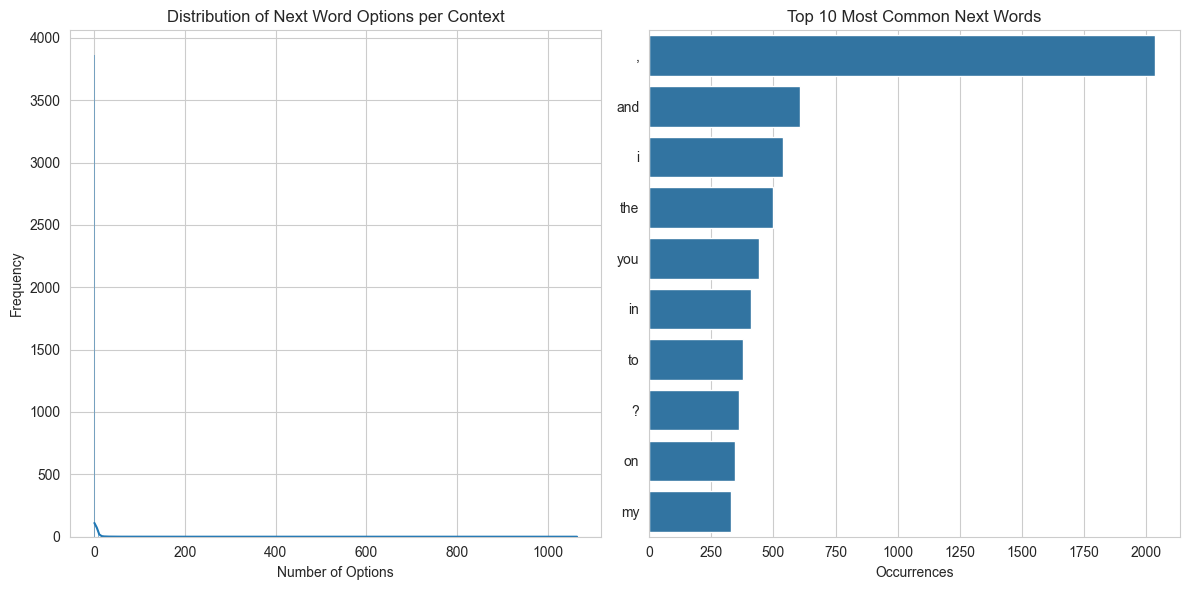

Model Analysis (Order 2):

Total contexts: 32420
Total next words: 51322
Average next words per context: 1.58

Top 10 contexts with most options:
', i' → 162 unique options
'in the' → 128 unique options
', you' → 104 unique options
', the' → 100 unique options
', im' → 96 unique options
'on the' → 94 unique options
', and' → 74 unique options
'to the' → 68 unique options
'me ,' → 60 unique options
', my' → 60 unique options

Top 20 most common next words:
',': 3784 occurrences
'the': 1615 occurrences
'i': 1445 occurrences
'you': 1287 occurrences
'a': 983 occurrences
'and': 913 occurrences
'to': 741 occurrences
'my': 729 occurrences
'in': 649 occurrences
'me': 616 occurrences
'that': 527 occurrences
'?': 503 occurrences
'on': 489 occurrences
'it': 487 occurrences
'im': 439 occurrences
'of': 439 occurrences
'your': 419 occurrences
'is': 376 occurrences
'for': 357 occurrences
'with': 348 occurrences


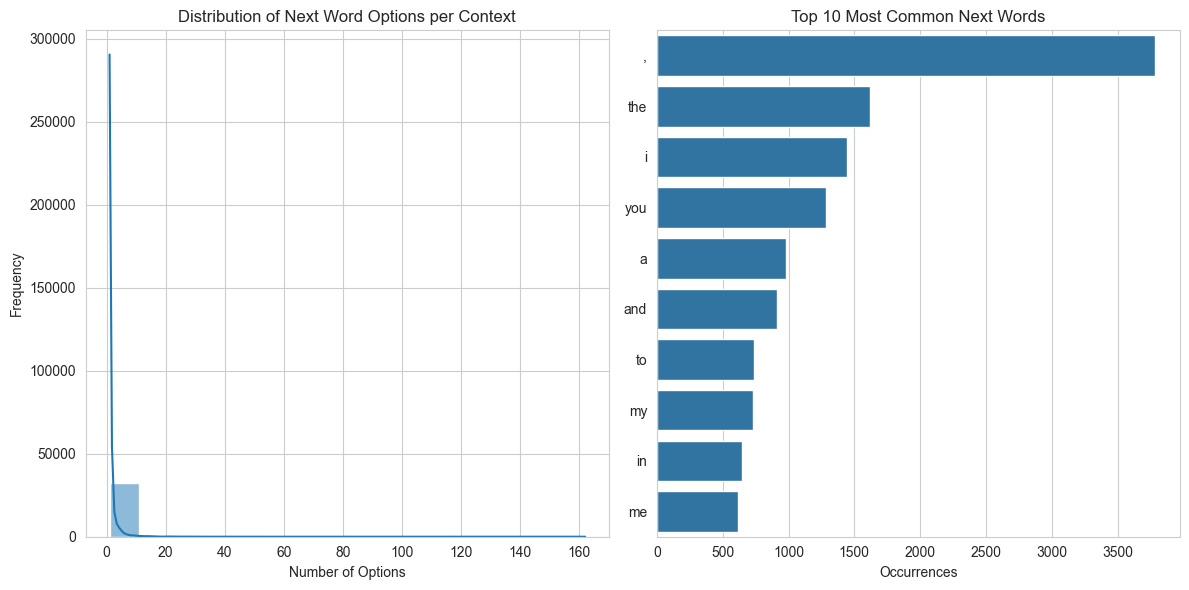

Model Analysis (Order 3):

Total contexts: 50712
Total next words: 56074
Average next words per context: 1.11

Top 10 contexts with most options:
'might also like' → 56 unique options
', i know' → 28 unique options
', oh ,' → 27 unique options
', i got' → 22 unique options
', nigga ,' → 19 unique options
', i can' → 19 unique options
'take off the' → 19 unique options
', yeah ,' → 18 unique options
', i dont' → 15 unique options
', my nigga' → 15 unique options

Top 20 most common next words:
',': 4426 occurrences
'the': 1876 occurrences
'i': 1726 occurrences
'you': 1526 occurrences
'a': 1157 occurrences
'and': 955 occurrences
'to': 840 occurrences
'my': 808 occurrences
'me': 739 occurrences
'in': 693 occurrences
'that': 588 occurrences
'it': 551 occurrences
'?': 541 occurrences
'on': 519 occurrences
'of': 512 occurrences
'im': 488 occurrences
'your': 443 occurrences
'is': 412 occurrences
'for': 379 occurrences
'with': 362 occurrences


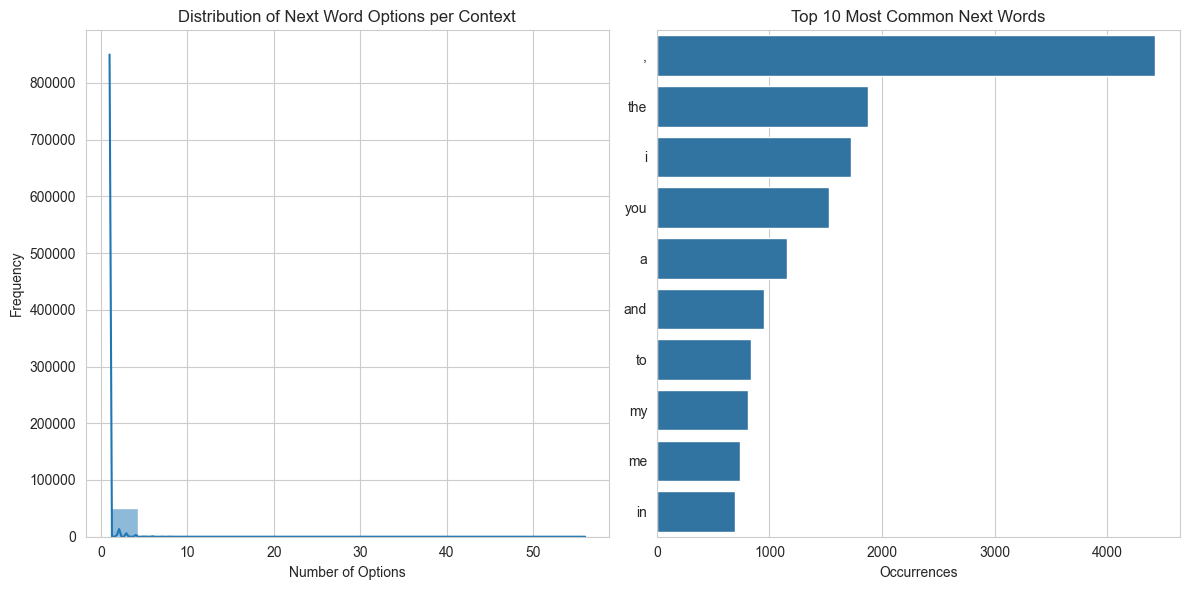

Model Analysis (Order 4):

Total contexts: 55411
Total next words: 57060
Average next words per context: 1.03

Top 10 contexts with most options:
'you might also like' → 56 unique options
'bish , ya bish' → 12 unique options
', take off the' → 12 unique options
'might also like i' → 11 unique options
'i cant please everybody' → 10 unique options
'dont kill my vibe' → 8 unique options
', no , no' → 8 unique options
'im tripping and falling' → 8 unique options
'up , hol up' → 7 unique options
'baby , im high' → 7 unique options

Top 20 most common next words:
',': 4631 occurrences
'the': 1930 occurrences
'i': 1779 occurrences
'you': 1579 occurrences
'a': 1174 occurrences
'and': 974 occurrences
'to': 861 occurrences
'my': 816 occurrences
'me': 752 occurrences
'in': 693 occurrences
'that': 601 occurrences
'it': 559 occurrences
'?': 553 occurrences
'of': 526 occurrences
'on': 514 occurrences
'im': 506 occurrences
'your': 448 occurrences
'is': 418 occurrences
'for': 381 occurrences
'like': 3

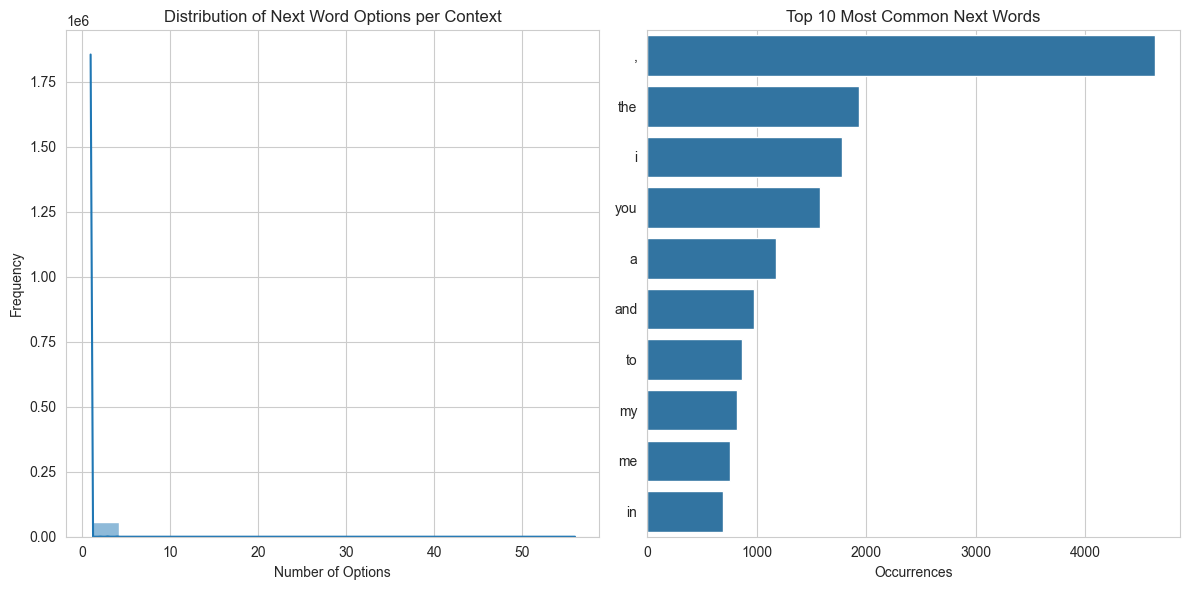

Model Analysis (Order 5):

Total contexts: 56379
Total next words: 57276
Average next words per context: 1.02

Top 10 contexts with most options:
'ya bish , ya bish' → 12 unique options
'you might also like i' → 11 unique options
', dont kill my vibe' → 8 unique options
'and im tripping and falling' → 8 unique options
'hol up , hol up' → 7 unique options
', baby , im high' → 7 unique options
'get you high as this' → 7 unique options
'no , no , no' → 7 unique options
'i dont give a fuck' → 6 unique options
'you , you , you' → 6 unique options

Top 20 most common next words:
',': 4679 occurrences
'the': 1928 occurrences
'i': 1791 occurrences
'you': 1586 occurrences
'a': 1176 occurrences
'and': 972 occurrences
'to': 863 occurrences
'my': 814 occurrences
'me': 753 occurrences
'in': 687 occurrences
'that': 604 occurrences
'it': 558 occurrences
'?': 536 occurrences
'of': 527 occurrences
'im': 517 occurrences
'on': 516 occurrences
'your': 446 occurrences
'is': 418 occurrences
'like': 391 occu

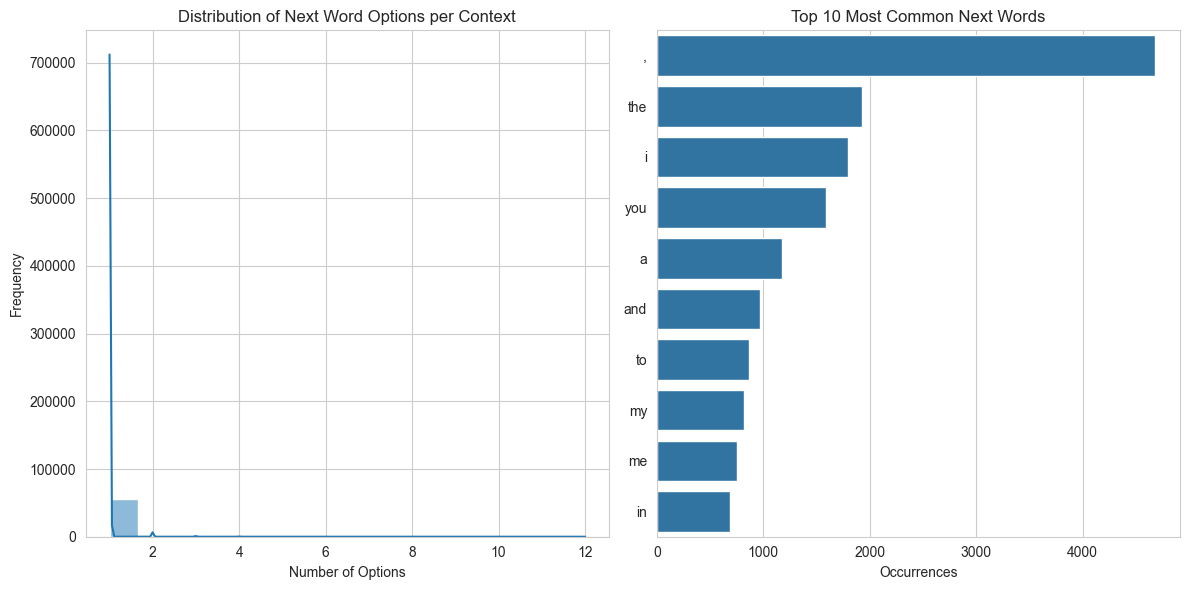

In [68]:
def analyze_model(model):
    """Analyze the Markov model and return insights."""
    if not model.model:
        return "Model is empty."
    
    # Count the number of contexts and next words
    context_count = len(model.model)
    next_word_count = sum(len(nexts) for nexts in model.model.values())
    avg_next_words = next_word_count / context_count
    
    # Find the contexts with the most options
    contexts_by_options = sorted(model.model.items(), key=lambda x: len(x[1]), reverse=True)
    top_contexts = contexts_by_options[:10]
    
    # Find the most common next words overall
    all_next_words = [word for words in model.model.values() for word in words]
    word_counts = {}
    for word in all_next_words:
        word_counts[word] = word_counts.get(word, 0) + 1
    top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]
    
    # Print the analysis
    print(f"Model Analysis (Order {model.order}):\n")
    print(f"Total contexts: {context_count}")
    print(f"Total next words: {next_word_count}")
    print(f"Average next words per context: {avg_next_words:.2f}")
    
    print("\nTop 10 contexts with most options:")
    for context, next_words in top_contexts:
        print(f"'{' '.join(context)}' → {len(set(next_words))} unique options")
    
    print("\nTop 20 most common next words:")
    for word, count in top_words:
        print(f"'{word}': {count} occurrences")
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Distribution of next word options
    options_dist = [len(nexts) for nexts in model.model.values()]
    plt.subplot(1, 2, 1)
    sns.histplot(options_dist, kde=True)
    plt.title("Distribution of Next Word Options per Context")
    plt.xlabel("Number of Options")
    plt.ylabel("Frequency")
    
    # Top words visualization
    plt.subplot(1, 2, 2)
    top_10_words = dict(top_words[:10])
    sns.barplot(x=list(top_10_words.values()), y=list(top_10_words.keys()))
    plt.title("Top 10 Most Common Next Words")
    plt.xlabel("Occurrences")
    
    plt.tight_layout()
    plt.show()

# Analyze the models if trained
if 'models' in locals() and models:
    for order, model in models.items():
        analyze_model(model)
else:
    print("Models not trained, cannot analyze.")